# Denoising AutoEncoder

Explore the use of an autoencoder for image infill.   In this case the synthetic image is two crossed lines of two colors, with a field of gaussian green noise.  The synthetic "noise" is the removal of a box somewhere on the line.

A second effort was to observe the relationship between the matrix condition of a layer and the training loss.


In [147]:
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.callbacks import Callback
from numpy.linalg import qr, cond

from keras.layers import *
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import *
#os.environ['CUDA_VISIBLE_DEVICES']=''

WIDTH = 128
HEIGHT = 128
BOX = 12
def green(img):
    x = np.array(img)
    x[:,:,1] = np.random.standard_normal((WIDTH, HEIGHT))/1.5
    return Image.fromarray(x)

def blank(img):
    arr = np.array(img)
    x = np.random.randint(WIDTH) #(BOX, WIDTH-BOX)
    y = np.random.randint(HEIGHT) #(BOX, HEIGHT-BOX)
    y = np.argmax(arr[x,:,0])
     
    
    arr[x-BOX:x+BOX, y-BOX:y+BOX,:]=0
    return Image.fromarray(arr)

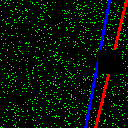

In [148]:
def makeImage(colors=False):

    if(colors==True):
        c1=(255,0,0)
        c2=(0,0,255)
    else:
        c1=(255,255,255)
        c2=(255,255,255)
        
    startx1 = np.random.randint(WIDTH)
    endx1 = np.random.randint(WIDTH)
    startx2 = np.random.randint(WIDTH)
    endx2 = np.random.randint(WIDTH)

    img = np.zeros((WIDTH, HEIGHT))
    img = Image.fromarray(img).convert("RGB")
    img = green(img)
    draw = ImageDraw.Draw(img)
    draw.line([startx1,0,endx1,HEIGHT],fill=c1, width=3)
    draw.line([startx2,0,endx2,HEIGHT],fill=c2 ,width=3)
   # draw.line([0, np.random.randint(WIDTH), WIDTH, np.random.randint(WIDTH)], width=3)
    return img

 
blank(makeImage(True))
 

In [149]:
def generateData(n, colors):
    x_train=[]
    x_noise=[]
    for i in range(n):
        img = makeImage(colors)
        x_train.append(np.array(img))
        x_noise.append(np.array(blank(img)))

    x_train = np.array(x_train)
    x_noise = np.array(x_noise)

    x_train = x_train/255.
    x_noise = x_noise/255.
    return x_train, x_noise

In [150]:

class MyCB (Callback):
    def on_epoch_end(self, epoch, logs):
        if(epoch % 2 ==0):  
            # print(epoch)
            # make and save an image
            img = makeImage()
            img = np.array(img)
            img = np.array(blank(img))/255.
            img = np.reshape(img, (1,WIDTH, HEIGHT,3))
            images.append(autoencoder.predict(img)) 
            
        # save the condition of the decoder dense layer
        x = autoencoder.layers[2].layers[1].get_weights()[0]
        q,r =qr(x)
        results.append(cond(r))
        loss.append(logs['loss'])
        

In [151]:

def makeModel(latent_dim, layer_filters):
    input_shape = (WIDTH, HEIGHT, 3)  # one or 3 dim

    batch_size = 128
    kernel_size = 3
    #layer_filters = [16, 16, 32, 64, 128]

    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs

    for filters in layer_filters:
        x = Conv2D(filters=filters,

                   kernel_size=kernel_size,
                   strides=2,
                   activation='relu',
                   padding='same')(x)

    shape = K.int_shape(x)
    x=MaxPooling2D(2)(x)

    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)
    encoder = Model(inputs, latent, name='encoder')

    ### now build decoder

    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=2,
                            activation='relu',
                            padding='same')(x)

    x = Conv2DTranspose(filters=3,
                        kernel_size=kernel_size,
                        padding='same')(x)

    outputs = Activation('sigmoid', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return autoencoder


In [152]:
def doResults():
    img = makeImage(True)
    img = np.array(img)
    img = np.array(blank(img))/255.
    img = np.reshape(img, (1,WIDTH, HEIGHT,3))

    image = autoencoder.predict(img) 

    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    plt.imshow(image[0])

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(results)
    plt.title("Layer COndition")
    plt.grid()


    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.title("Model Loss")
    plt.grid()

120


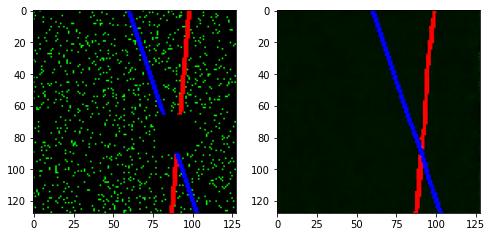

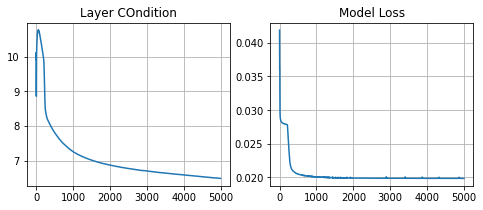

In [154]:
bottleneck=120
results =[]
images = []
loss=[]
x_train, x_noise = generateData(8000, True)
autoencoder = makeModel(bottleneck, [16,16,32])
autoencoder.compile(loss='mse', optimizer='adagrad') 
autoencoder.fit(x_noise, x_train,  batch_size=64, verbose=False, callbacks=[MyCB()], epochs=5000)
print(bottleneck)
doResults()

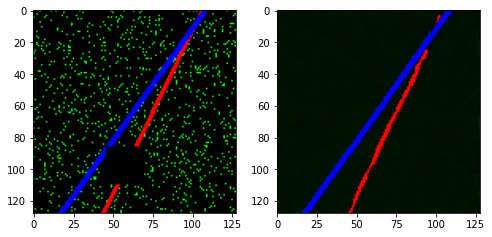

In [162]:
img = makeImage(True)
img = np.array(img)
img = np.array(blank(img))/255.
img = np.reshape(img, (1,WIDTH, HEIGHT,3))

image = autoencoder.predict(img) 

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(image[0])